In [81]:
from pylab import rcParams
import pandas as pd
from utilsforecast.plotting import plot_series
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor': '#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12}
plt.rcParams.update(dark_style)


rcParams['figure.figsize'] = (8, 4)

In [82]:
df = pd.read_excel('../Data/IDA & DA Ierland 2023.xlsx')
da = pd.DataFrame({
    'ds': df['Datetime'],
    'unique_id': 1,
    'y': df['IE DA EUR']
})
ida1 = pd.DataFrame({
    'ds': df['Datetime'],
    'unique_id': 1,
    'y': df['IE IDA1 EUR price']
})
ida2 = pd.DataFrame({
    'ds': df['Datetime'],
    'unique_id': 1,
    'y': df['IE IDA2 EUR price']
})

In [83]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# seasonal_decompose(ida1["y"], model='additive', period=2000).plot()

In [84]:
ida1['y'].describe()

count    17520.000000
mean       120.171648
std         45.898827
min        -38.840000
25%         93.930000
50%        114.950000
75%        144.812500
max        366.820000
Name: y, dtype: float64

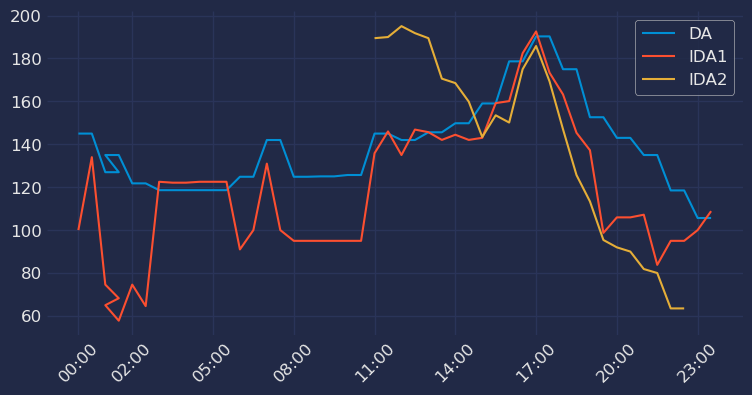

In [85]:
sample_day = df.sample(n=1)
sample_da = da[da['ds'].dt.date == sample_day['Datetime'].dt.date.values[0]]
sample_ida1 = ida1[ida1['ds'].dt.date ==
                   sample_day['Datetime'].dt.date.values[0]]
sample_ida2 = ida2[ida2['ds'].dt.date ==
                   sample_day['Datetime'].dt.date.values[0]]
plt.plot(sample_da['ds'], sample_da['y'], label='DA')
plt.plot(sample_ida1['ds'], sample_ida1['y'], label='IDA1')
plt.plot(sample_ida2['ds'], sample_ida2['y'], label='IDA2')

plt.xticks(sample_da['ds'][::6], sample_da['ds'].dt.strftime(
    '%H:%M')[::6], rotation=45)
plt.legend()
plt.show()

Correlation: 0.9339517969580933


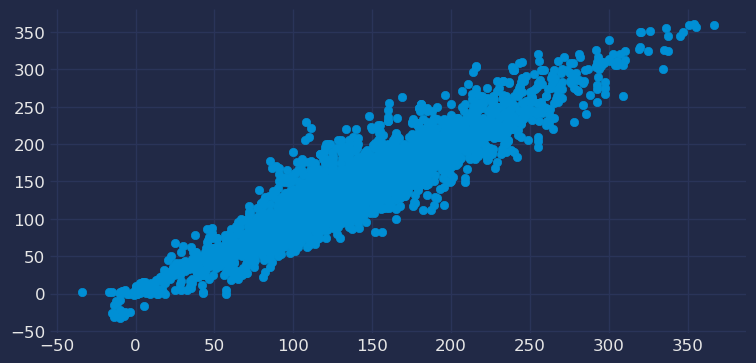

In [86]:
from scipy.stats import pearsonr

ida_combined = ida1.merge(ida2, on='ds', suffixes=('_ida1', '_ida2'))
ida_combined.dropna(inplace=True)
plt.scatter(ida_combined['y_ida1'], ida_combined['y_ida2'])
corr, _ = pearsonr(ida_combined['y_ida1'], ida_combined['y_ida2'])
print("Correlation:", corr)

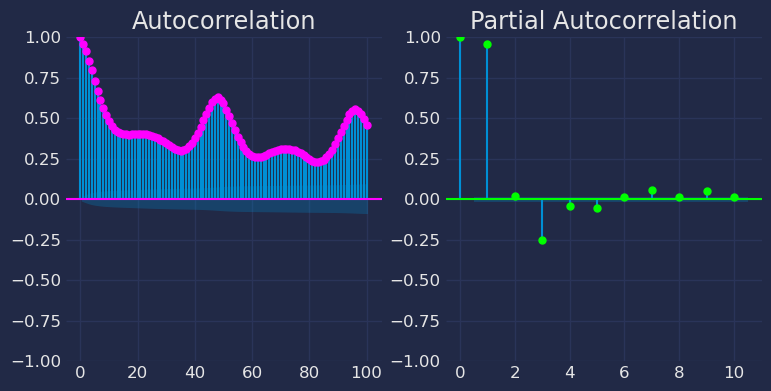

In [87]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(ida1["y"],  lags=100, ax=axs[0], color="fuchsia")
axs[0].set_title("Autocorrelation")

plot_pacf(ida1["y"],  lags=10, ax=axs[1], color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show()

In [88]:
train_ida1, test_ida1 = ida1[ida1['ds'].dt.month <
                             12], ida1[ida1['ds'].dt.month >= 12]
train_ida2, test_ida2 = ida2[ida2['ds'].dt.month <
                             12], ida2[ida2['ds'].dt.month >= 12]
train_da,   test_da = da[da['ds'].dt.month <
                         12],     da[da['ds'].dt.month >= 12]

In [89]:
test_da.isna().sum()

ds           0
unique_id    0
y            0
dtype: int64

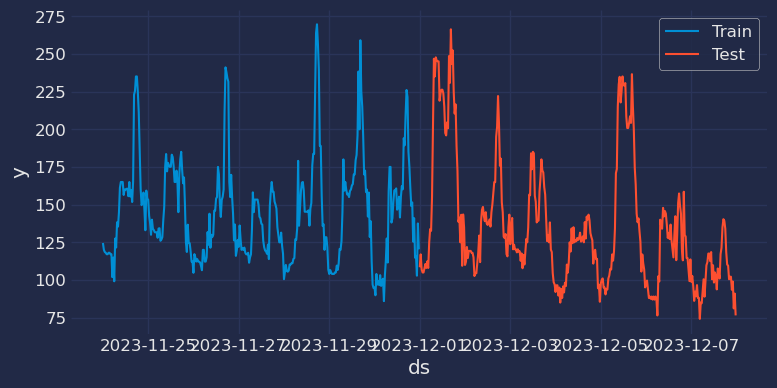

In [90]:
import seaborn as sns
sns.lineplot(train_ida1.tail(48*7), x="ds", y="y", label="Train")
sns.lineplot(test_ida1.head(48*7), x="ds", y="y", label="Test")
plt.show()

## MSTL


In [91]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA


def create_MSTL(seasons=[2, 4, 6, 8, 10, 48]):
    '''X_df is used to pass exogenous variables'''
    models = [
        MSTL(season_length=seasons,
             trend_forecaster=AutoARIMA(seasonal=True)
             )
    ]

    sf = StatsForecast(
        models=models,
        freq='30min',
    )

    return sf

In [92]:
da_model = create_MSTL([48, 2*48, 5*48, 6*48])
da_prediction = da_model.forecast(df=train_da, h=48)
da_prediction = da_prediction.merge(test_da.head(48), on='ds')

/Users/tijnschutte/opt/anaconda3/envs/scriptie/lib/python3.11/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


MAE: 29.43


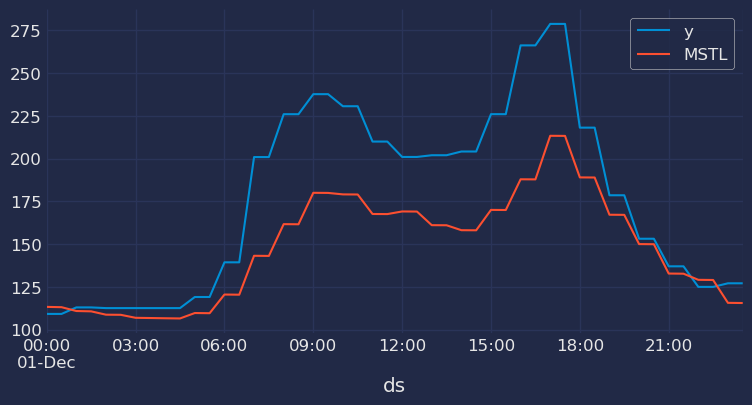

In [93]:
da_prediction.plot('ds', ['y', 'MSTL'])
mae = abs(da_prediction['y']-da_prediction['MSTL']).mean()
# da_prediction.to_excel('../Data/DA_forecast.xlsx')
print('MAE:', str(round(mae, 2)))

In [94]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA
from statsforecast.utils import ConformalIntervals

day = 48  # 48 half hours in a day
intervals = ConformalIntervals(h=day, n_windows=10)

models = [
    MSTL(
        season_length=[day, 2*day, 5*day, 6*day],
        trend_forecaster=AutoARIMA(
            seasonal=True, prediction_intervals=intervals)
    )
]

sf = StatsForecast(
    models=models,
    freq='30min',
)

In [95]:
ida1_prediction = sf.forecast(df=train_ida1, h=day)
ida1_prediction = ida1_prediction.merge(test_ida1.head(day), on='ds')

/Users/tijnschutte/opt/anaconda3/envs/scriptie/lib/python3.11/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [96]:
# ida1_prediction.to_excel('../Data/IDA1_forecast.xlsx')

MAE: 26.12


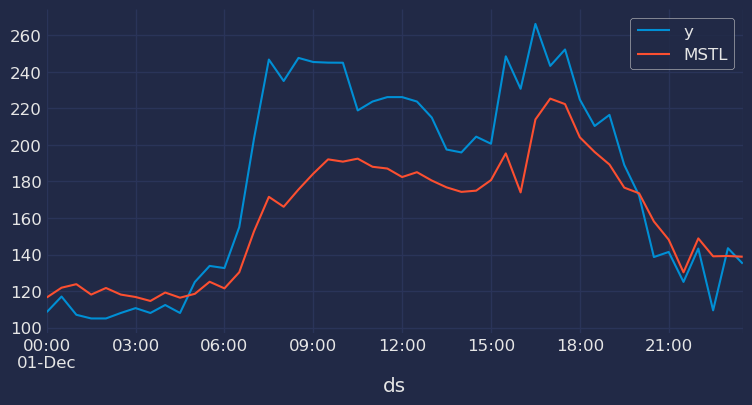

In [97]:
ida1_prediction.plot('ds', ['y', 'MSTL'])
mae = abs(ida1_prediction['y']-ida1_prediction['MSTL']).mean()
print('MAE:', str(round(mae, 2)))

In [98]:
train_exo = train_ida1.merge(train_da, on='ds', suffixes=(
    '', '_da')).drop(columns='unique_id_da')
test_exo = test_ida1.merge(test_da, on='ds', suffixes=(
    '', '_da')).drop(columns='unique_id_da')

prediction_exo = sf.forecast(df=train_exo, h=day, X_df=test_da.head(day))
prediction_exo = prediction_exo.merge(test_ida1.head(day), on='ds')

/Users/tijnschutte/opt/anaconda3/envs/scriptie/lib/python3.11/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


MAE: 19.05


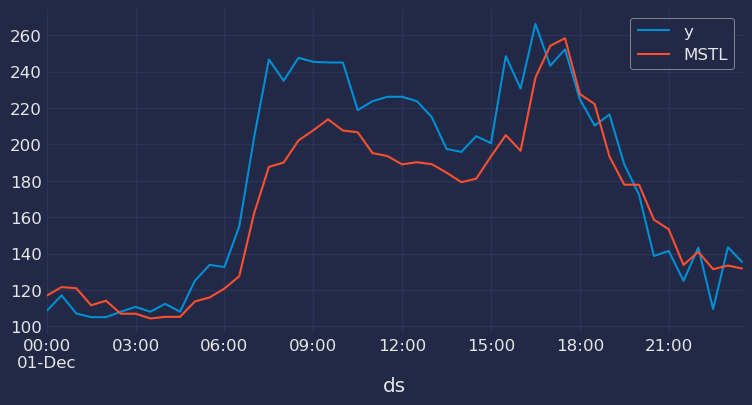

In [99]:
prediction_exo.plot('ds', ['y', 'MSTL'])
mae = abs(prediction_exo['y'] - prediction_exo['MSTL']).mean()
print('MAE:', str(round(mae, 2)))

In [100]:
# sf.fit(train_exo)

In [101]:
# hist_trend = sf.fitted_[0, 0].model_.set_index(train_exo['ds'])
# hist_trend_distr = hist_trend['trend'].groupby(
#     [hist_trend.index.hour, hist_trend.index.minute]).describe()

In [102]:
# hist_errors = sf.fitted_[0, 0].model_.set_index(train_exo['ds'])['remainder']
# hist_errors_distr = hist_errors.groupby(
#     [hist_errors.index.hour, hist_errors.index.minute]).describe()
# hist_errors_distr.head(2)

In [103]:
# def generate_scenarios(predictions, hist_errors_distr, n_scenarios=10):
#     scenarios = [predictions]
#     for _ in range(n_scenarios):
#         sampled_errors_high = hist_errors_distr.apply(
#             lambda row: np.random.uniform(row['25%'], row['max']), axis=1)
#         sampled_errors_med = hist_errors_distr.apply(
#             lambda row: np.random.uniform(row['25%'], row['75%']), axis=1)
#         sampled_errors_low = hist_errors_distr.apply(
#             lambda row: np.random.uniform(row['min'], row['75%']), axis=1)

#         scenario_low = pd.Series(
#             predictions + sampled_errors_low.values, name='S_low').rolling(3).mean().fillna(method='bfill')
#         scenario_med = pd.Series(
#             predictions + sampled_errors_med.values, name='S_med').rolling(3).mean().fillna(method='bfill')
#         scenario_high = pd.Series(
#             predictions + sampled_errors_high.values, name='S_high').rolling(3).mean().fillna(method='bfill')
#         scenarios.append(scenario_low)
#         scenarios.append(scenario_med)
#         scenarios.append(scenario_high)
#     return scenarios


# scenarios = generate_scenarios(
#     prediction_exo['MSTL'], hist_errors_distr, n_scenarios=3)
# scenarios = pd.DataFrame(scenarios).T

# plt.plot(prediction_exo['ds'], scenarios)
# plt.plot(prediction_exo['ds'], prediction_exo['y'], label='True')
# plt.legend()
# plt.show()

In [104]:
# scenarios['y'] = prediction_exo['y'].values
# scenarios.to_excel('../Data/scenarios.xlsx', index=False)

In [105]:
res = {
    "2023-12-01": {
        "overall_profit": 3478.9000000000015,
        "stages": {
            "DA - IDA1": {
                "cvar": 8144.249939477439,
                "actual_profit": -30547.9,
                "forecasted_profit": -26143.390159606934,
                "scenario_stats": {
                    "IDA1_profit_std": 4783.028498380556,
                    "IDA1_profit": 23564.40224636059
                }
            },
            "IDA1 - IDA2": {
                "cvar": 3061.420082730615,
                "actual_profit": 24779.300000000003,
                "forecasted_profit": 23267.63095855713,
                "scenario_stats": {
                    "IDA2_profit_std": 1584.8468253766914,
                    "IDA2_profit": 7746.93408419832
                }
            },
            "IDA2": {
                "actual_profit": 9247.5,
                "forecasted_profit": 10615.434646606445
            }
        }
    },
    "2023-12-02": {
        "overall_profit": 1813.3499999999985,
        "stages": {
            "DA - IDA1": {
                "cvar": 1085.7180833982698,
                "actual_profit": -975.7000000000004,
                "forecasted_profit": -1061.9799804687498,
                "scenario_stats": {
                    "IDA1_profit_std": 620.1131222524137,
                    "IDA1_profit": 4052.313976794092
                }
            },
            "IDA1 - IDA2": {
                "cvar": 5176.923116458601,
                "actual_profit": 18945.25,
                "forecasted_profit": 22827.696838378906,
                "scenario_stats": {
                    "IDA2_profit_std": 2940.3148018176953,
                    "IDA2_profit": -20182.2424533215
                }
            },
            "IDA2": {
                "actual_profit": -16156.2,
                "forecasted_profit": -15576.337432861328
            }
        }
    },
    "2023-12-03": {
        "overall_profit": 2271.45,
        "stages": {
            "DA - IDA1": {
                "cvar": 3329.4099091309,
                "actual_profit": 9739.8,
                "forecasted_profit": 14083.453483581543,
                "scenario_stats": {
                    "IDA1_profit_std": 1591.935993570832,
                    "IDA1_profit": -12150.631784490703
                }
            },
            "IDA1 - IDA2": {
                "cvar": 2162.378607638732,
                "actual_profit": -13406.1,
                "forecasted_profit": -14750.750732421875,
                "scenario_stats": {
                    "IDA2_profit_std": 1234.6571568943436,
                    "IDA2_profit": 5243.5378762279415
                }
            },
            "IDA2": {
                "actual_profit": 5937.750000000001,
                "forecasted_profit": 6781.053848266602
            }
        }
    },
    "2023-12-04": {
        "overall_profit": 1871.800000000001,
        "stages": {
            "DA - IDA1": {
                "cvar": 141.38933548434514,
                "actual_profit": 2488.2,
                "forecasted_profit": 3069.224510192871,
                "scenario_stats": {
                    "IDA1_profit_std": 104.71048570883364,
                    "IDA1_profit": 833.3801723414772
                }
            },
            "IDA1 - IDA2": {
                "cvar": 4391.340150746994,
                "actual_profit": 9902.2,
                "forecasted_profit": 12830.604286193848,
                "scenario_stats": {
                    "IDA2_profit_std": 2370.841852657637,
                    "IDA2_profit": -13429.262130397494
                }
            },
            "IDA2": {
                "actual_profit": -10518.6,
                "forecasted_profit": -9327.016983032227
            }
        }
    },
    "2023-12-05": {
        "overall_profit": 3445.250000000002,
        "stages": {
            "DA - IDA1": {
                "cvar": 5437.482191099134,
                "actual_profit": 22071.600000000002,
                "forecasted_profit": 18826.556091308594,
                "scenario_stats": {
                    "IDA1_profit_std": 2990.4362677238382,
                    "IDA1_profit": -19367.36080510702
                }
            },
            "IDA1 - IDA2": {
                "cvar": 1237.0101153082226,
                "actual_profit": -19420.25,
                "forecasted_profit": -15715.488624572754,
                "scenario_stats": {
                    "IDA2_profit_std": 895.4347948686327,
                    "IDA2_profit": 255.4195038856094
                }
            },
            "IDA2": {
                "actual_profit": 793.8999999999999,
                "forecasted_profit": 787.4502563476556
            }
        }
    },
    "2023-12-06": {
        "overall_profit": 1636.4999999999989,
        "stages": {
            "DA - IDA1": {
                "cvar": 2793.6483356230547,
                "actual_profit": 7379.7,
                "forecasted_profit": 9249.584922790527,
                "scenario_stats": {
                    "IDA1_profit_std": 1477.3835638138305,
                    "IDA1_profit": -7828.973509531183
                }
            },
            "IDA1 - IDA2": {
                "cvar": 1251.33121771714,
                "actual_profit": -7036.3,
                "forecasted_profit": -7859.187088012694,
                "scenario_stats": {
                    "IDA2_profit_std": 975.3205663611819,
                    "IDA2_profit": 2262.5647664497496
                }
            },
            "IDA2": {
                "actual_profit": 1293.0999999999992,
                "forecasted_profit": 2559.703712463379
            }
        }
    },
    "2023-12-07": {
        "overall_profit": 2453.149999999999,
        "stages": {
            "DA - IDA1": {
                "cvar": 5311.085054794659,
                "actual_profit": -12279.8,
                "forecasted_profit": -14847.172622680664,
                "scenario_stats": {
                    "IDA1_profit_std": 3158.9148476245923,
                    "IDA1_profit": 14058.416502000113
                }
            },
            "IDA1 - IDA2": {
                "cvar": 789.8324171409222,
                "actual_profit": 12718.199999999999,
                "forecasted_profit": 17499.555168151855,
                "scenario_stats": {
                    "IDA2_profit_std": 428.91995902871673,
                    "IDA2_profit": 1801.2147404337638
                }
            },
            "IDA2": {
                "actual_profit": 2014.7499999999995,
                "forecasted_profit": 2118.450164794922
            }
        }
    },
    "2023-12-08": {
        "overall_profit": 1989.3499999999992,
        "stages": {
            "DA - IDA1": {
                "cvar": 8037.915314707313,
                "actual_profit": 21420.0,
                "forecasted_profit": 23002.6664352417,
                "scenario_stats": {
                    "IDA1_profit_std": 4667.96959586114,
                    "IDA1_profit": -25726.39838727093
                }
            },
            "IDA1 - IDA2": {
                "cvar": 920.3500008092649,
                "actual_profit": -21266.95,
                "forecasted_profit": -20742.254734039307,
                "scenario_stats": {
                    "IDA2_profit_std": 480.9320170466604,
                    "IDA2_profit": 2343.043525998445
                }
            },
            "IDA2": {
                "actual_profit": 1836.3,
                "forecasted_profit": 3165.5952453613286
            }
        }
    },
    "2023-12-09": {
        "overall_profit": 2605.1999999999985,
        "stages": {
            "DA - IDA1": {
                "cvar": 7792.596131711966,
                "actual_profit": 18184.6,
                "forecasted_profit": 25089.28783416748,
                "scenario_stats": {
                    "IDA1_profit_std": 4644.934375815906,
                    "IDA1_profit": -28298.449820399015
                }
            },
            "IDA1 - IDA2": {
                "cvar": 1972.5534968469217,
                "actual_profit": -13233.85,
                "forecasted_profit": -15237.663917541504,
                "scenario_stats": {
                    "IDA2_profit_std": 993.962381421909,
                    "IDA2_profit": -5373.359643273835
                }
            },
            "IDA2": {
                "actual_profit": -2345.5499999999997,
                "forecasted_profit": -3886.1135482788077
            }
        }
    },
    "2023-12-10": {
        "overall_profit": 1965.8000000000015,
        "stages": {
            "DA - IDA1": {
                "cvar": 8835.013496229692,
                "actual_profit": -17673.2,
                "forecasted_profit": -16230.48095703125,
                "scenario_stats": {
                    "IDA1_profit_std": 5290.512784346691,
                    "IDA1_profit": 13197.108137611254
                }
            },
            "IDA1 - IDA2": {
                "cvar": 647.7631536174576,
                "actual_profit": 20502.850000000002,
                "forecasted_profit": 24725.856857299805,
                "scenario_stats": {
                    "IDA2_profit_std": 347.7179894399904,
                    "IDA2_profit": -1052.3371169129875
                }
            },
            "IDA2": {
                "actual_profit": -863.8499999999999,
                "forecasted_profit": -638.1656265258789
            }
        }
    }
}

In [106]:
res2 = {
    "2023-12-01": {
        "overall_profit": 5519.392685636611,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": 1932.6879333278264,
                "forecasted_profit": 1356.3012525730842,
                "scenario_stats": {
                    "IDA1_profit_std": 5.3304459514375065e-12,
                    "IDA1_profit": 2336.0556895301356
                }
            },
            "IDA1 - IDA2": {
                "cvar": 0.0,
                "actual_profit": 1442.9261804602522,
                "forecasted_profit": 1080.7758495967942,
                "scenario_stats": {
                    "IDA2_profit_std": 2.463622890096583e-12,
                    "IDA2_profit": 2640.2268130435828
                }
            },
            "IDA2": {
                "actual_profit": 2143.778571848532,
                "forecasted_profit": 2915.732259238478
            }
        }
    },
    "2023-12-02": {
        "overall_profit": 2494.757411501231,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": 1769.449257983935,
                "forecasted_profit": 2406.473670717296,
                "scenario_stats": {
                    "IDA1_profit_std": 3.4279927912820134e-12,
                    "IDA1_profit": 1302.9865271762037
                }
            },
            "IDA1 - IDA2": {
                "cvar": 0.0,
                "actual_profit": 300.4790225054883,
                "forecasted_profit": 264.22306576381425,
                "scenario_stats": {
                    "IDA2_profit_std": 1.1242932773781028e-12,
                    "IDA2_profit": 1200.197129212023
                }
            },
            "IDA2": {
                "actual_profit": 424.82913101180816,
                "forecasted_profit": 1371.806851042805
            }
        }
    },
    "2023-12-03": {
        "overall_profit": 2465.4579254262817,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": 2782.906671346909,
                "forecasted_profit": 3442.522006348285,
                "scenario_stats": {
                    "IDA1_profit_std": 1.2960000320922314e-11,
                    "IDA1_profit": 1267.9679587877954
                }
            },
            "IDA1 - IDA2": {
                "cvar": 0.0,
                "actual_profit": -1907.6706612347853,
                "forecasted_profit": 973.6658935898126,
                "scenario_stats": {
                    "IDA2_profit_std": 1.4909888987635896e-12,
                    "IDA2_profit": 1506.068366742058
                }
            },
            "IDA2": {
                "actual_profit": 1590.221915314158,
                "forecasted_profit": 1753.3798968323363
            }
        }
    },
    "2023-12-04": {
        "overall_profit": 1734.8991324342198,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": 2079.4688331055213,
                "forecasted_profit": 2711.555741466648,
                "scenario_stats": {
                    "IDA1_profit_std": 1.0737238838480693e-12,
                    "IDA1_profit": 1263.6722535978975
                }
            },
            "IDA1 - IDA2": {
                "cvar": 0.0,
                "actual_profit": 905.6336650807965,
                "forecasted_profit": 1854.7733451626011,
                "scenario_stats": {
                    "IDA2_profit_std": 1.60435451871391e-12,
                    "IDA2_profit": 553.7374962847475
                }
            },
            "IDA2": {
                "actual_profit": -1250.203365752098,
                "forecasted_profit": 593.4352045004769
            }
        }
    },
    "2023-12-05": {
        "overall_profit": 3892.327160709083,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": 3627.789804483703,
                "forecasted_profit": 3833.7169908708474,
                "scenario_stats": {
                    "IDA1_profit_std": 4.4208459289749306e-12,
                    "IDA1_profit": 122.86083358962242
                }
            },
            "IDA1 - IDA2": {
                "cvar": 0.0,
                "actual_profit": -1909.8028029740035,
                "forecasted_profit": -748.6058505852707,
                "scenario_stats": {
                    "IDA2_profit_std": 1.5891777143230277e-12,
                    "IDA2_profit": 2005.0086356413976
                }
            },
            "IDA2": {
                "actual_profit": 2174.3401591993834,
                "forecasted_profit": 2297.580029659117
            }
        }
    },
    "2023-12-06": {
        "overall_profit": 3170.7886480256134,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": 1758.4771055407175,
                "forecasted_profit": 2469.869991100415,
                "scenario_stats": {
                    "IDA1_profit_std": 4.635301113311291e-12,
                    "IDA1_profit": 1137.6798564689125
                }
            },
            "IDA1 - IDA2": {
                "cvar": 68.20366680722194,
                "actual_profit": 514.638408500184,
                "forecasted_profit": -124.07342696585499,
                "scenario_stats": {
                    "IDA2_profit_std": 267.3488241542431,
                    "IDA2_profit": 1866.2386754083432
                }
            },
            "IDA2": {
                "actual_profit": 897.673133984712,
                "forecasted_profit": 1923.9714098041622
            }
        }
    },
    "2023-12-07": {
        "overall_profit": 2154.514397456534,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": -442.32424446393134,
                "forecasted_profit": 102.58462272928045,
                "scenario_stats": {
                    "IDA1_profit_std": 2.817966266744346e-12,
                    "IDA1_profit": 3464.7220900402244
                }
            },
            "IDA1 - IDA2": {
                "cvar": 0.0,
                "actual_profit": 2117.832266610501,
                "forecasted_profit": 4400.986560906545,
                "scenario_stats": {
                    "IDA2_profit_std": 1.8495961061857934e-12,
                    "IDA2_profit": 137.60622695698737
                }
            },
            "IDA2": {
                "actual_profit": 479.00637530996437,
                "forecasted_profit": -9.840006570880291
            }
        }
    },
    "2023-12-08": {
        "overall_profit": 1389.5148591833208,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": 2453.11792094069,
                "forecasted_profit": 3283.483929882706,
                "scenario_stats": {
                    "IDA1_profit_std": 1.2744213375890499e-12,
                    "IDA1_profit": 374.35384146992925
                }
            },
            "IDA1 - IDA2": {
                "cvar": 0.0,
                "actual_profit": -1863.6505678135231,
                "forecasted_profit": 82.26114275525299,
                "scenario_stats": {
                    "IDA2_profit_std": 1.2781555890392334e-12,
                    "IDA2_profit": 1651.2389017250057
                }
            },
            "IDA2": {
                "actual_profit": 800.047506056154,
                "forecasted_profit": 1737.070006886567
            }
        }
    },
    "2023-12-09": {
        "overall_profit": 1932.2705453511824,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": 2381.9391374371608,
                "forecasted_profit": 2808.848200748782,
                "scenario_stats": {
                    "IDA1_profit_std": 2.0904162455723483e-12,
                    "IDA1_profit": 517.7677600179824
                }
            },
            "IDA1 - IDA2": {
                "cvar": 0.0,
                "actual_profit": -461.49719675712186,
                "forecasted_profit": 1356.8413321550133,
                "scenario_stats": {
                    "IDA2_profit_std": 2.1585160957085685e-12,
                    "IDA2_profit": 431.83878339949
                }
            },
            "IDA2": {
                "actual_profit": 11.82860467114341,
                "forecasted_profit": 481.65819067930397
            }
        }
    },
    "2023-12-10": {
        "overall_profit": 3075.699113439856,
        "stages": {
            "DA - IDA1": {
                "cvar": 0.0,
                "actual_profit": 1231.4662703267657,
                "forecasted_profit": 1446.6581094280446,
                "scenario_stats": {
                    "IDA1_profit_std": 3.1497614944322176e-12,
                    "IDA1_profit": 1393.6524078859206
                }
            },
            "IDA1 - IDA2": {
                "cvar": 3.0295765895971233e-13,
                "actual_profit": 1998.9663029265218,
                "forecasted_profit": 2404.5030082974454,
                "scenario_stats": {
                    "IDA2_profit_std": 6.928137826858679e-13,
                    "IDA2_profit": -418.8857165429579
                }
            },
            "IDA2": {
                "actual_profit": -154.73345981343186,
                "forecasted_profit": -542.7301669002954
            }
        }
    }
}

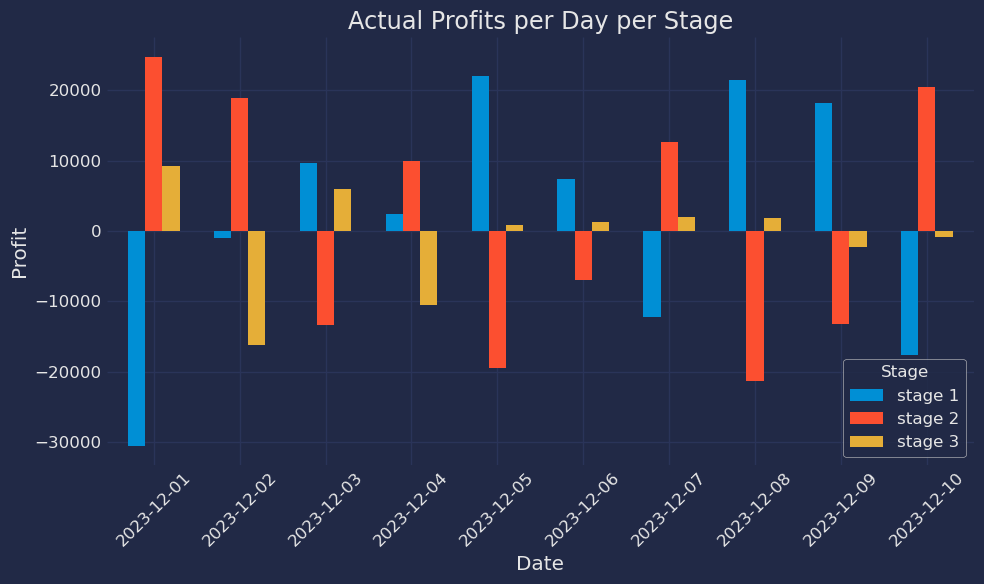

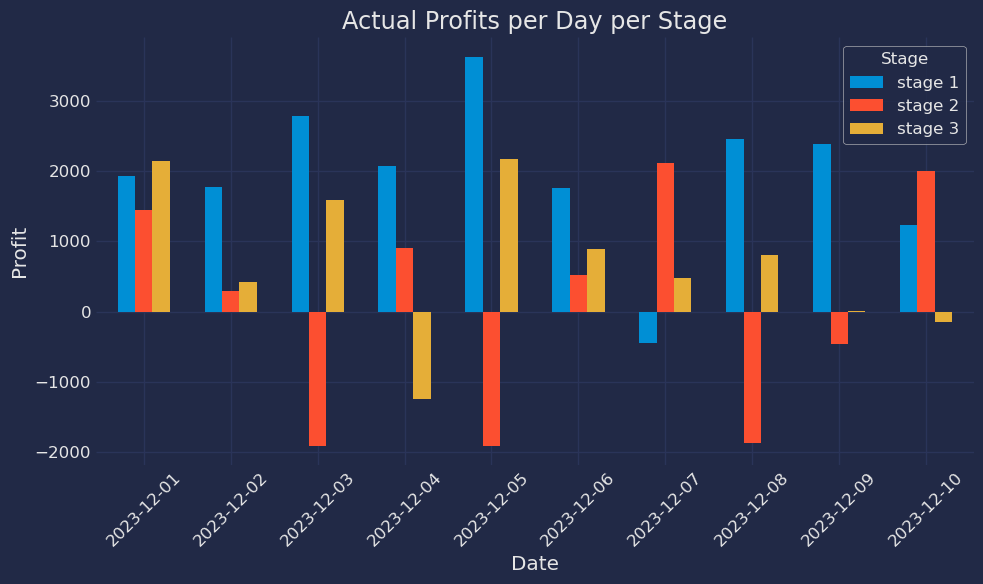

In [107]:
def plot_res(res):
    flattened_data = []

    for date, data in res.items():
        overall_profit = data['overall_profit']
        stages = data['stages']

        # Extract actual profits for each stage
        row = {
            'date': date,
            'stage 1': stages.get('DA - IDA1', {}).get('actual_profit', 0),
            'stage 2': stages.get('IDA1 - IDA2', {}).get('actual_profit', 0),
            'stage 3': stages.get('IDA2', {}).get('actual_profit', 0)
        }

        flattened_data.append(row)

    df = pd.DataFrame(flattened_data)
    df.set_index('date', inplace=True)

    ax = df.plot(kind='bar', figsize=(10, 6), width=0.6)
    plt.title('Actual Profits per Day per Stage')
    plt.ylabel('Profit')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.legend(title='Stage')
    plt.tight_layout()
    plt.show()



plot_res(res)
plot_res(res2)

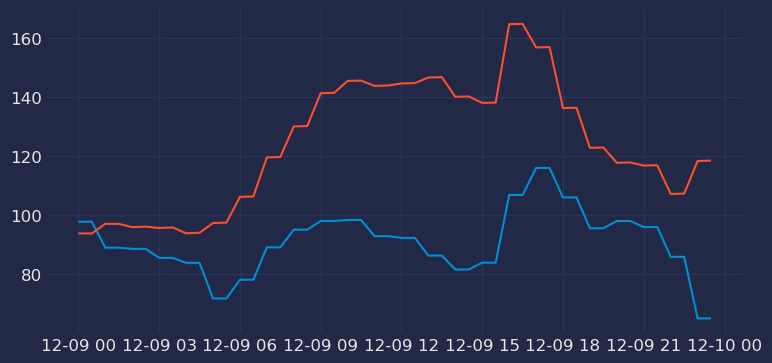

In [108]:
date = '2023-12-09'
weird = pd.read_excel(f'../Data/Forecasts/DA/{date}_exo[].xlsx')
date_mask = test_da['ds'].dt.date == weird['ds'].dt.date.values[0]
real = test_da.loc[date_mask]
# print(real)
plt.plot(real['ds'], real['y'], label='True')
plt.plot(weird['ds'], weird['MSTL'], label='DA')

### PAST ERRORS

In [109]:
# crossvalidation_df = sf.cross_validation(df=train_da,
#                                          h=48,
#                                          step_size=48,
#                                          n_windows=30)

In [110]:
# crossvalidation_df['error'] = crossvalidation_df['y'] - \
#     crossvalidation_df['MSTL']
# crossvalidation_df.to_excel('../Data/cross_val_30_days_da.xlsx')
crossvalidation_df = pd.read_excel(
    '../Data/Crossvalidation/cross_val_30_days_ida1.xlsx')
crossvalidation_df.head()

,ds,y,MSTL,error
0,2023-11-01 00:00:00,109.639999,113.844406,-4.204407
1,2023-11-01 00:30:00,108.480003,117.553726,-9.073723
2,2023-11-01 01:00:00,110.730003,119.143646,-8.413643
3,2023-11-01 01:30:00,66.610001,118.225021,-51.615021
4,2023-11-01 02:00:00,78.389999,118.200195,-39.810196


In [111]:
error_distr = crossvalidation_df.groupby(
    [crossvalidation_df['ds'].dt.hour, crossvalidation_df['ds'].dt.minute])['error'].describe()

In [188]:
# TODO peak variance to determine scenario shifts
peaks_y = crossvalidation_df.groupby(crossvalidation_df['ds'].dt.day)[
    'y'].apply(list).apply(lambda row: np.argmax(row))
peaks_mstl = crossvalidation_df.groupby(crossvalidation_df['ds'].dt.day)[
    'MSTL'].apply(list).apply(lambda row: np.argmax(row))
peaks_errors = peaks_y - peaks_mstl
peaks_errors.mean()

-1.3333333333333333

In [113]:
error_distr.head(2)

count      mean        std        min       25%       50%       75%  \
ds ds                                                                        
0  0    30.0 -0.790926  11.660295 -46.539436 -6.137966  1.113167  4.501883   
   30   30.0 -0.504557  12.949593 -38.553307 -6.418322  0.148403  8.876020   

             max  
ds ds             
0  0   17.872154  
   30  19.355263

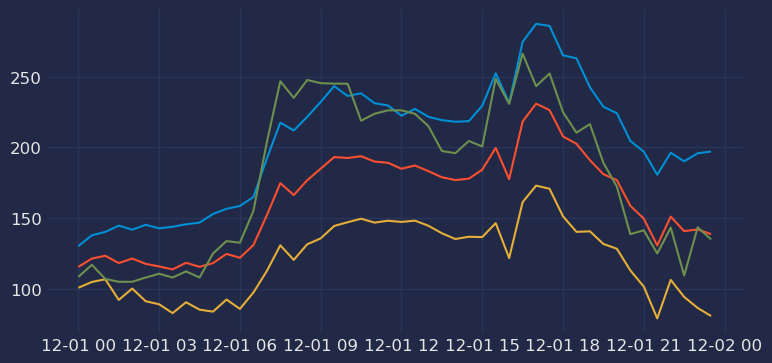

In [114]:
# TODO sample errors per percentile (per half-hour? per day?)

errors_high = error_distr.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), 90), axis=1)
errors_middle = error_distr.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), 50), axis=1)
errors_low = error_distr.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), 10), axis=1)

scenarios = np.vstack(
    [errors_high, errors_middle, errors_low]) + ida1_prediction['MSTL'].values
scenarios_df = pd.DataFrame(scenarios).T
scenarios_df.columns = ['S_high', 'S_med', 'S_low']
scenarios_df['y'] = ida1_prediction['y'].values
scenarios_df['MSTL'] = ida1_prediction['MSTL'].values
# scenarios_df.to_excel('../Data/scenarios.xlsx', index=False)
plt.plot(pd.DataFrame(scenarios).T.set_index(ida1_prediction['ds']))
plt.plot(ida1_prediction['ds'], ida1_prediction['y'], label='True')

In [115]:
def generate_scenarios(predictions):
    errors_high = error_distr.apply(lambda row: np.percentile(np.random.normal(
        row['mean'], row['std'], 10000), 90), axis=1)
    errors_middle = error_distr.apply(lambda row: np.percentile(np.random.normal(
        row['mean'], row['std'], 10000), 50), axis=1)
    errors_low = error_distr.apply(lambda row: np.percentile(np.random.normal(
        row['mean'], row['std'], 10000), 10), axis=1)

    scenarios = np.vstack(
        [errors_high, errors_middle, errors_low]) + predictions
    scenarios_df = pd.DataFrame(scenarios).T
    scenarios_df.columns = ['high', 'middle', 'low']
    return scenarios_df

In [116]:
scenarios = crossvalidation_df.groupby(crossvalidation_df['ds'].dt.day)[
    'MSTL'].apply(list).apply(lambda row: generate_scenarios(row))

In [117]:
scenarios = pd.concat(scenarios.values)

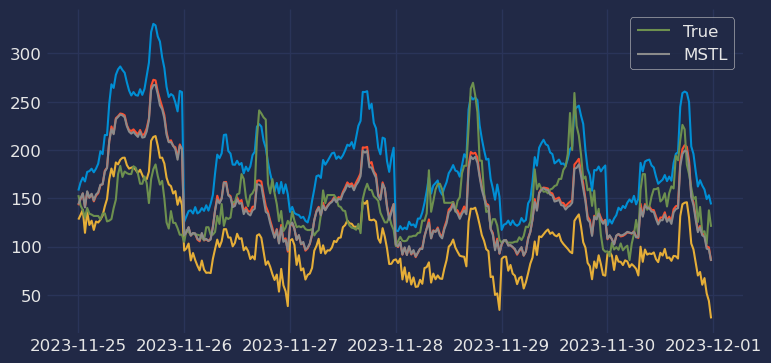

In [118]:
window = 6*48
plt.plot(crossvalidation_df['ds'].tail(window), scenarios.tail(window))
plt.plot(crossvalidation_df['ds'].tail(window),
         crossvalidation_df['y'].tail(window), label='True')
plt.plot(crossvalidation_df['ds'].tail(
    window), crossvalidation_df['MSTL'].tail(window), label='MSTL')
plt.legend()

In [119]:
# crossvalidation_ida2 = pd.read_excel('../Data/Crossvalidation/cross_val_30_days_ida2.xlsx')

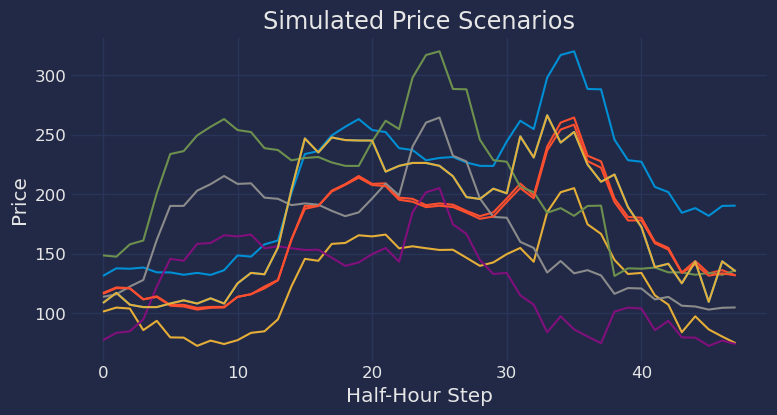

In [194]:
# num_simulations = 20
# mean_error, std_error = stats.norm.fit(crossvalidation_df['error'])

high = 90
med = 50
low = 10

error_distr_per_halfhour = crossvalidation_df.groupby(
    [crossvalidation_df['ds'].dt.hour, crossvalidation_df['ds'].dt.minute])['error'].describe()

high_error = error_distr_per_halfhour.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), high), axis=1).values
medium_error = error_distr_per_halfhour.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), med), axis=1).values
low_error = error_distr_per_halfhour.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), low), axis=1).values

high_noise = np.full((1, 48), high_error)
med_noise = np.full((1, 48), medium_error)
low_noise = np.full((1, 48), low_error)

# Combine scenarios
simulated_scenarios = np.vstack([
    high_noise, med_noise, low_noise,
]) + prediction_exo['MSTL'].values

# Create shifted versions of the scenarios
shifted_scenarios = []
for i in range(len(simulated_scenarios)):
    shifted_scenarios.append(np.roll(simulated_scenarios[i], shift=-10))

simulated_scenarios = np.vstack([simulated_scenarios, *shifted_scenarios])
scenarios = pd.DataFrame(simulated_scenarios).T


def rolling(list):
    return list.rolling(3).mean().fillna(method='bfill')


# scenarios = scenarios.apply(rolling, axis=0)

scenarios.columns = [f"S_{i}" for i in range(len(scenarios.columns))]
scenarios['y'] = prediction_exo['y'].values
scenarios['MSTL'] = prediction_exo['MSTL'].values
# scenarios.to_excel('../Data/scenarios.xlsx', index=False)

plt.plot(scenarios)
plt.plot(prediction_exo['y'], label='True')
plt.xlabel('Half-Hour Step')
plt.ylabel('Price')
plt.title('Simulated Price Scenarios')
plt.show()

In [121]:
import json
res = {
    "2023-12-01": {
        "overall_profit": 3478.9000000000015,
        "stages": {
            "IDA1": {
                "cvar": 8158.060892747421,
                "actual_profit": -30547.9,
                "forecasted_profit": -26143.390159606934,
                "scenario_stats": {
                    "total_profit_std": 6570.816365781396,
                    "total_max_profit": 39907.8845135935,
                    "total_min_profit": 23605.52819784212
                }
            },
            "IDA2": {
                "cvar": 3078.0496397446846,
                "actual_profit": 24779.300000000003,
                "forecasted_profit": 23267.63095855713,
                "scenario_stats": {
                    "total_profit_std": 2018.9680183836379,
                    "total_max_profit": 13922.439603484561,
                    "total_min_profit": 7720.2985839224775
                }
            }
        }
    },
    "2023-12-02": {
        "overall_profit": 1854.6499999999978,
        "stages": {
            "IDA1": {
                "cvar": 694.5587908766183,
                "actual_profit": 515.2999999999997,
                "forecasted_profit": 624.4132995605469,
                "scenario_stats": {
                    "total_profit_std": 483.12855332220255,
                    "total_max_profit": 4181.557599013477,
                    "total_min_profit": 2787.1904412417407
                }
            },
            "IDA2": {
                "cvar": 5215.469522019366,
                "actual_profit": 17495.55,
                "forecasted_profit": 21142.802124023438,
                "scenario_stats": {
                    "total_profit_std": 4071.4151187629004,
                    "total_max_profit": -9867.853537981737,
                    "total_min_profit": -20293.501988090564
                }
            }
        }
    },
    "2023-12-03": {
        "overall_profit": 2271.45,
        "stages": {
            "IDA1": {
                "cvar": 3430.874036899888,
                "actual_profit": 9739.8,
                "forecasted_profit": 14083.453483581543,
                "scenario_stats": {
                    "total_profit_std": 2147.1817945645994,
                    "total_max_profit": -5966.2229864190895,
                    "total_min_profit": -12241.850068711705
                }
            },
            "IDA2": {
                "cvar": 2179.6810436299693,
                "actual_profit": -13406.1,
                "forecasted_profit": -14750.750732421875,
                "scenario_stats": {
                    "total_profit_std": 1431.5544735635888,
                    "total_max_profit": 9799.977088833537,
                    "total_min_profit": 5299.646912384951
                }
            }
        }
    },
    "2023-12-04": {
        "overall_profit": 1800.3999999999996,
        "stages": {
            "IDA1": {
                "cvar": 311.8054950366028,
                "actual_profit": 1108.8,
                "forecasted_profit": 1624.045753479004,
                "scenario_stats": {
                    "total_profit_std": 335.26876246118474,
                    "total_max_profit": 3249.91142360932,
                    "total_min_profit": 2228.646948841204
                }
            },
            "IDA2": {
                "cvar": 4308.443128918033,
                "actual_profit": 11210.2,
                "forecasted_profit": 14236.789779663086,
                "scenario_stats": {
                    "total_profit_std": 3184.1573972709607,
                    "total_max_profit": -5005.892064743901,
                    "total_min_profit": -13551.806015326478
                }
            }
        }
    },
    "2023-12-05": {
        "overall_profit": 3490.45,
        "stages": {
            "IDA1": {
                "cvar": 5068.233228234676,
                "actual_profit": 21027.6,
                "forecasted_profit": 17797.847213745117,
                "scenario_stats": {
                    "total_profit_std": 3814.5813667883194,
                    "total_max_profit": -8017.800542825404,
                    "total_min_profit": -18106.771814196352
                }
            },
            "IDA2": {
                "cvar": 1237.5235622007513,
                "actual_profit": -21617.1,
                "forecasted_profit": -17603.367500305176,
                "scenario_stats": {
                    "total_profit_std": 835.0590652559805,
                    "total_max_profit": 5772.628582102582,
                    "total_min_profit": 3246.0099910965523
                }
            }
        }
    },
    "2023-12-06": {
        "overall_profit": 1636.4999999999989,
        "stages": {
            "IDA1": {
                "cvar": 2961.3634323497563,
                "actual_profit": 7379.7,
                "forecasted_profit": 9249.584922790527,
                "scenario_stats": {
                    "total_profit_std": 2011.5157082428775,
                    "total_max_profit": -1895.2633780083213,
                    "total_min_profit": -7989.366389806825
                }
            },
            "IDA2": {
                "cvar": 1320.0424431690449,
                "actual_profit": -7036.3,
                "forecasted_profit": -7859.187088012695,
                "scenario_stats": {
                    "total_profit_std": 1047.245958298574,
                    "total_max_profit": 5111.2343864119275,
                    "total_min_profit": 2282.480814167288
                }
            }
        }
    },
    "2023-12-07": {
        "overall_profit": 2477.449999999998,
        "stages": {
            "IDA1": {
                "cvar": 6386.633448537202,
                "actual_profit": -14693.4,
                "forecasted_profit": -18018.320236206055,
                "scenario_stats": {
                    "total_profit_std": 5115.347797534971,
                    "total_max_profit": 29676.711137216997,
                    "total_min_profit": 16408.713135404945
                }
            },
            "IDA2": {
                "cvar": 2678.762674834097,
                "actual_profit": 10708.099999999999,
                "forecasted_profit": 14729.766654968262,
                "scenario_stats": {
                    "total_profit_std": 2012.8631228880342,
                    "total_max_profit": 11325.644657360604,
                    "total_min_profit": 5931.268079192721
                }
            }
        }
    },
    "2023-12-08": {
        "overall_profit": 1692.4000000000024,
        "stages": {
            "IDA1": {
                "cvar": 6975.964749015412,
                "actual_profit": 18070.800000000003,
                "forecasted_profit": 18867.69115447998,
                "scenario_stats": {
                    "total_profit_std": 5275.056018657922,
                    "total_max_profit": -7114.2442515824205,
                    "total_min_profit": -20793.12018543245
                }
            },
            "IDA2": {
                "cvar": 2258.057332023901,
                "actual_profit": -20646.95,
                "forecasted_profit": -19955.819416046143,
                "scenario_stats": {
                    "total_profit_std": 1647.5778480110012,
                    "total_max_profit": 9581.76931231542,
                    "total_min_profit": 4979.44982471008
                }
            }
        }
    },
    "2023-12-09": {
        "overall_profit": 1278.1,
        "stages": {
            "IDA1": {
                "cvar": 6338.945664398436,
                "actual_profit": 14508.3,
                "forecasted_profit": 19766.07318878174,
                "scenario_stats": {
                    "total_profit_std": 5006.795415298278,
                    "total_max_profit": -9208.096813876564,
                    "total_min_profit": -21766.083018242363
                }
            },
            "IDA2": {
                "cvar": 1130.8278638972674,
                "actual_profit": -14597.8,
                "forecasted_profit": -16783.050804138184,
                "scenario_stats": {
                    "total_profit_std": 775.6919744587384,
                    "total_max_profit": 4431.623546477701,
                    "total_min_profit": 2071.190298646961
                }
            }
        }
    },
    "2023-12-10": {
        "overall_profit": 2068.800000000002,
        "stages": {
            "IDA1": {
                "cvar": 9434.11072989923,
                "actual_profit": -18689.5,
                "forecasted_profit": -17263.16749572754,
                "scenario_stats": {
                    "total_profit_std": 7736.950355556038,
                    "total_max_profit": 33345.91924902222,
                    "total_min_profit": 14348.407755048034
                }
            },
            "IDA2": {
                "cvar": 275.37853390156135,
                "actual_profit": 20502.850000000002,
                "forecasted_profit": 24725.856857299805,
                "scenario_stats": {
                    "total_profit_std": 218.4773058378364,
                    "total_max_profit": 771.7954996758182,
                    "total_min_profit": 145.67998626153508
                }
            }
        }
    }
}
actual_profits_per_stage_per_day = {
    date: {stage: details["actual_profit"]
           for stage, details in data["stages"].items()}
    for date, data in res.items()
}
for date in actual_profits_per_stage_per_day:
    actual_profits_per_stage_per_day[date]["Profit"] = actual_profits_per_stage_per_day[date]["IDA1"] + \
        actual_profits_per_stage_per_day[date]["IDA2"]

pretty_printed = json.dumps(actual_profits_per_stage_per_day, indent=4)
print(pretty_printed)

{
    "2023-12-01": {
        "IDA1": -30547.9,
        "IDA2": 24779.300000000003,
        "Profit": -5768.5999999999985
    },
    "2023-12-02": {
        "IDA1": 515.2999999999997,
        "IDA2": 17495.55,
        "Profit": 18010.85
    },
    "2023-12-03": {
        "IDA1": 9739.8,
        "IDA2": -13406.1,
        "Profit": -3666.300000000001
    },
    "2023-12-04": {
        "IDA1": 1108.8,
        "IDA2": 11210.2,
        "Profit": 12319.0
    },
    "2023-12-05": {
        "IDA1": 21027.6,
        "IDA2": -21617.1,
        "Profit": -589.5
    },
    "2023-12-06": {
        "IDA1": 7379.7,
        "IDA2": -7036.3,
        "Profit": 343.39999999999964
    },
    "2023-12-07": {
        "IDA1": -14693.4,
        "IDA2": 10708.099999999999,
        "Profit": -3985.300000000001
    },
    "2023-12-08": {
        "IDA1": 18070.800000000003,
        "IDA2": -20646.95,
        "Profit": -2576.149999999998
    },
    "2023-12-09": {
        "IDA1": 14508.3,
        "IDA2": -14597.8,


#### Error distribution per half hour


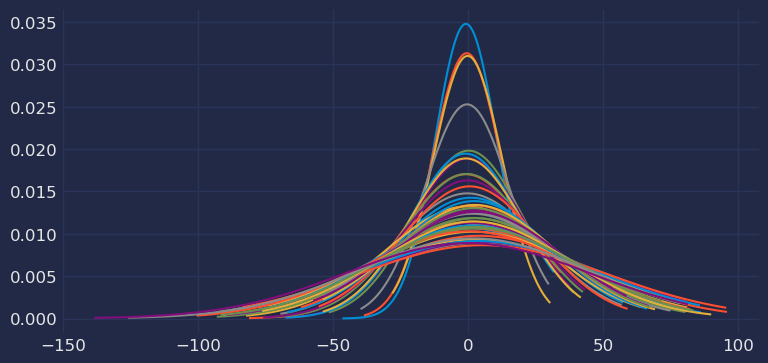

In [122]:
from scipy.stats import norm

errors_grouped = crossvalidation_df.groupby(
    [crossvalidation_df['ds'].dt.hour, crossvalidation_df['ds'].dt.minute])['error'].apply(list)

for errors in errors_grouped:
    mean, std = norm.fit(errors)
    x = np.linspace(min(errors), max(errors), 100)
    pdf = norm.pdf(x, mean, std)
    plt.plot(x, pdf)

#### Split errors into segments, for each segment create a scenario (with weight)

##### Doesn't allow for shifting, because then what would be the weight of that scenario?


In [123]:
# SPINNING WHEEL method (TODO)

error_segments = [
    (-3*std, -std),  # Large negative error
    (-std, 0),       # Small negative error
    (0, std),        # Zero error
    (std, 3*std)     # Small positive error, Large positive error can be combined
]

# Calculate weights based on historical error frequencies
weights = []
for segment in error_segments:
    lower, upper = segment
    error_counts = errors_grouped.apply(lambda errors: sum(
        [lower <= error <= upper for error in errors]))
    weight = error_counts.sum() / len(errors_grouped.sum())
    weights.append(weight)

print(weights)

[0.08333333333333333, 0.3597222222222222, 0.46597222222222223, 0.09027777777777778]


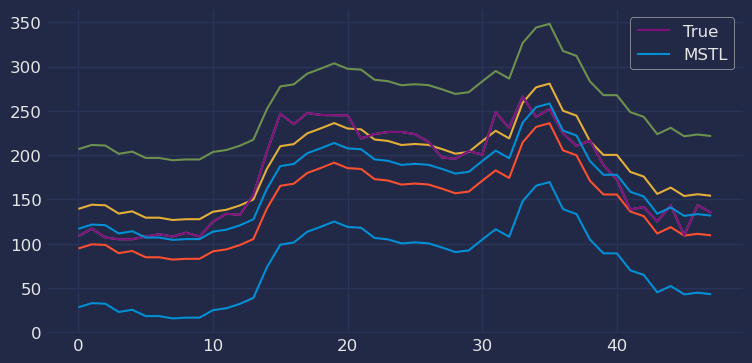

In [124]:
simulated_scenarios = []
for segment in error_segments:
    lower, upper = segment
    med = 50
    medium_error = np.percentile(np.random.uniform(
        lower, upper, 10000), med)
    med_noise = np.full((1, 48), medium_error)
    scenarios = med_noise + prediction_exo['MSTL'].values
    simulated_scenarios.append(scenarios)

simulated_scenarios = np.vstack(simulated_scenarios)
scenarios = pd.DataFrame(simulated_scenarios).T
scenarios.columns = [f"S_{i}" for i in range(len(scenarios.columns))]
scenarios['y'] = prediction_exo['y'].values

plt.plot(scenarios)
scenarios['MSTL'] = prediction_exo['MSTL'].values
# scenarios.to_excel('../Data/scenarios_with_weights.xlsx', index=False)

plt.plot(prediction_exo['y'], label='True')
plt.plot(prediction_exo['MSTL'], label='MSTL')
plt.legend()

/var/folders/fh/3_8gd_b93dl_hngm8f0nz6gw0000gn/T/ipykernel_19233/1299935558.py:37: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return list.rolling(3).mean().fillna(method='bfill')


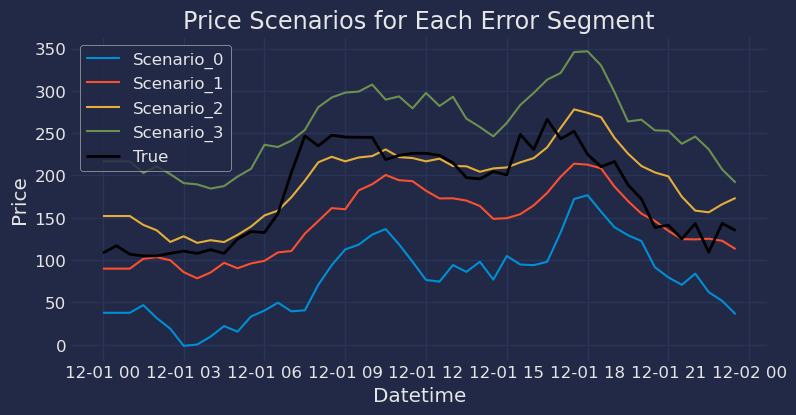

[0.08333333333333333, 0.3597222222222222, 0.46597222222222223, 0.09027777777777778]


In [125]:
# Generate scenarios for each error segment
scenarios = []
for lower, upper in error_segments:
    segment_errors = np.random.uniform(
        lower, upper, len(prediction_exo['MSTL']))
    scenario = prediction_exo['MSTL'] + segment_errors
    scenarios.append(scenario)

# Convert scenarios to DataFrame
scenarios_df = pd.DataFrame(scenarios).T
scenarios_df = scenarios_df.apply(rolling, axis=0)
scenarios_df.columns = [f'Scenario_{i}' for i in range(len(scenarios))]
scenarios_df['ds'] = prediction_exo['ds']
scenarios_df['y'] = prediction_exo['y']

# Plot the scenarios
for col in scenarios_df.columns[:-2]:
    plt.plot(scenarios_df['ds'], scenarios_df[col], label=col)
plt.plot(scenarios_df['ds'], scenarios_df['y'],
         label='True', color='black', linewidth=2)
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title('Price Scenarios for Each Error Segment')
plt.legend()
plt.show()
print(weights)

## CI using price distribution


In [126]:
prediction1 = prediction_exo.copy()

In [127]:
high, middle, low = 0.9, 0.5, 0.1
train_distr = train_ida1.groupby([train_ida1['ds'].dt.dayofweek, train_ida1['ds'].dt.hour, train_ida1['ds'].dt.minute])[
    'y'].describe(percentiles=[low, middle, high])
train_distr.head(4)

count        mean        std    min     10%      50%      90%  \
ds ds ds                                                                  
0  0  0    48.0  105.817708  35.768283 -24.03  75.942  102.995  147.367   
      30   48.0  107.098958  39.651301 -20.00  75.126   99.505  153.190   
   1  0    48.0  104.985000  37.975428 -20.00  71.500   99.490  151.745   
      30   48.0  100.202500  38.507216 -18.09  66.277   97.885  150.675   

             max  
ds ds ds          
0  0  0   188.52  
      30  212.40  
   1  0   205.00  
      30  190.35

In [128]:
# BEGIN: Add confidence interval to cross_val based on historical price distribution
confidence_level = 0.95
z_score = 1.96

# Calculate the mean and standard deviation of the historical MSTL values
historical_mean = train_distr['mean']
historical_std = train_distr['std']

# Map the historical mean and std to the cross_val DataFrame
prediction1['historical_mean'] = prediction1['ds'].apply(lambda x: historical_mean.loc[(x.dayofweek, x.hour, x.minute)])
prediction1['historical_std'] = prediction1['ds'].apply(lambda x: historical_std.loc[(x.dayofweek, x.hour, x.minute)])

# Calculate the confidence intervals
prediction1['ci_lower'] = prediction1['MSTL'] - z_score * prediction1['historical_std'] / np.sqrt(len(prediction1))
prediction1['ci_upper'] = prediction1['MSTL'] + z_score * prediction1['historical_std'] / np.sqrt(len(prediction1))

prediction1[['ds', 'y', 'MSTL', 'ci_lower', 'ci_upper']].head(5)

,ds,y,MSTL,ci_lower,ci_upper
0,2023-12-01 00:00:00,108.45,116.820602,108.355378,125.285826
1,2023-12-01 00:30:00,117.00,121.549065,112.637598,130.460531
2,2023-12-01 01:00:00,107.01,120.894440,112.060155,129.728724
3,2023-12-01 01:30:00,105.00,111.533897,102.438436,120.629359
4,2023-12-01 02:00:00,105.00,114.051628,105.078106,123.025150


Coverage: 0.40


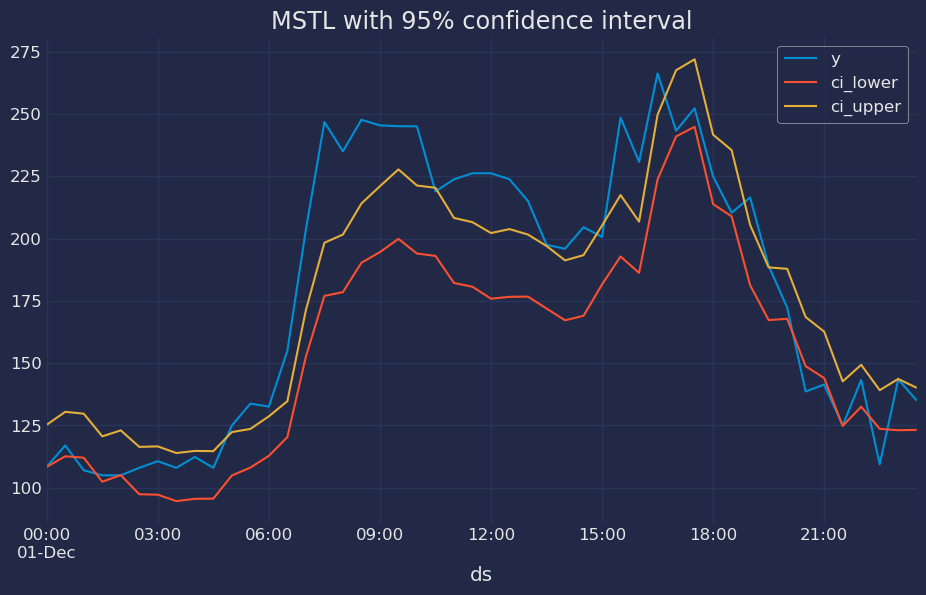

In [129]:
prediction1[['ds', 'y', 'ci_lower', 'ci_upper']].plot(x='ds', figsize=(10, 6), title='MSTL with 95% confidence interval')
coverage = ((prediction1['y'] >= prediction1['ci_lower']) & (prediction1['y'] <= prediction1['ci_upper'])).mean()
print(f'Coverage: {coverage:.2f}')

## CI - Multi Step Forecasting


In [149]:
ida1_prediction_copy = ida1_prediction.copy()

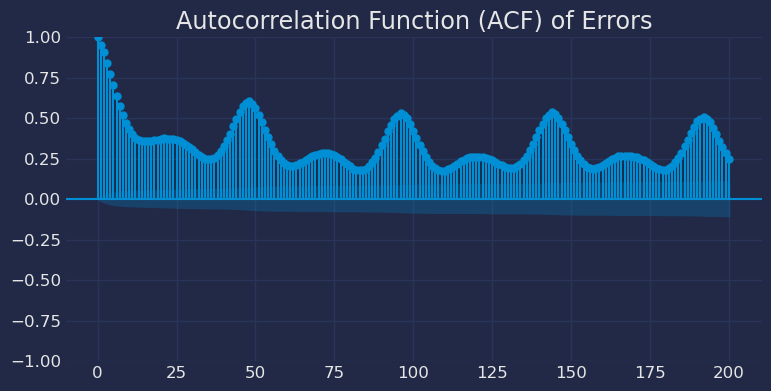

In [164]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(train_ida1['y'], lags=200)
plt.title('Autocorrelation Function (ACF) of Errors')
plt.show()

Coverage: 0.92


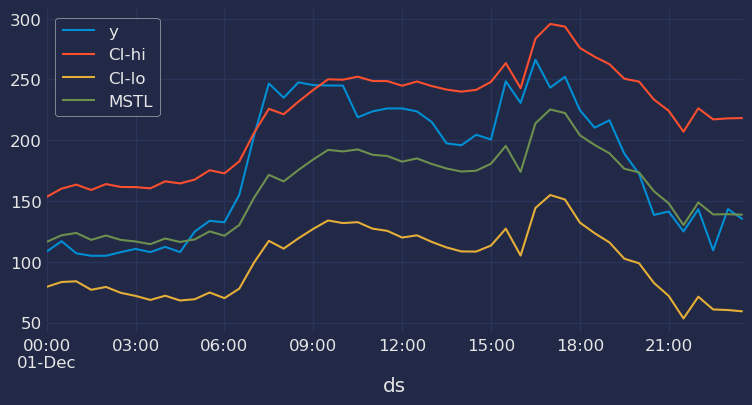

In [187]:
def create_ci_95(forecast, train):
    forecast = forecast.copy()
    z_score = 1.96
    rolling_window = 50  # Adjust the window size as needed
    se = train['y'].rolling(window=rolling_window).std().iloc[-1] / np.sqrt(len(forecast))
    forecast['h'] = forecast.groupby(
        forecast['ds'].dt.date).cumcount() + 1 + 12
    forecast['SE_h'] = se * np.sqrt(forecast['h'])
    forecast['CI-lo'] = forecast['MSTL'] - z_score * forecast['SE_h']
    forecast['CI-hi'] = forecast['MSTL'] + z_score * forecast['SE_h']
    forecast.drop(columns=['h'], inplace=True)
    if 'y' in forecast.columns:
        print('Coverage:', round(sum([1 for y, lo, hi in zip(
            forecast['y'], forecast['CI-lo'], forecast['CI-hi']) if lo <= y <= hi]) / len(forecast), 2))
    return forecast


prediction_with_ci = create_ci_95(ida1_prediction_copy, train_ida1)
prediction_with_ci[-48*3:].plot('ds', ['y', 'CI-hi', 'CI-lo', 'MSTL'])
plt.show()

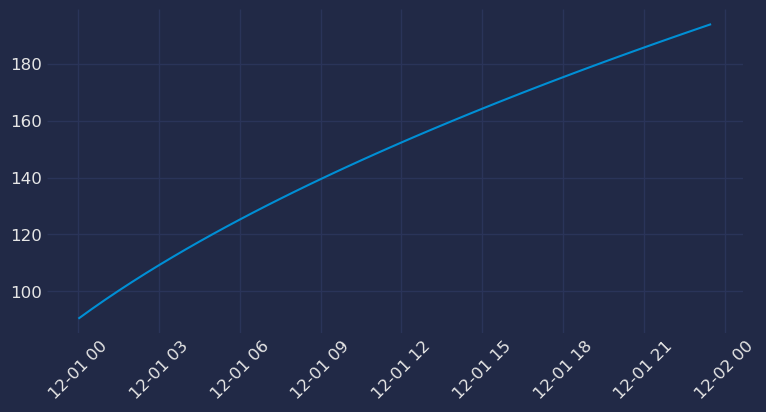

In [132]:
plt.plot(prediction_with_ci['ds'],
         prediction_with_ci['CI-hi'] - prediction_with_ci['CI-lo'])
plt.xticks(rotation=45)
plt.show()

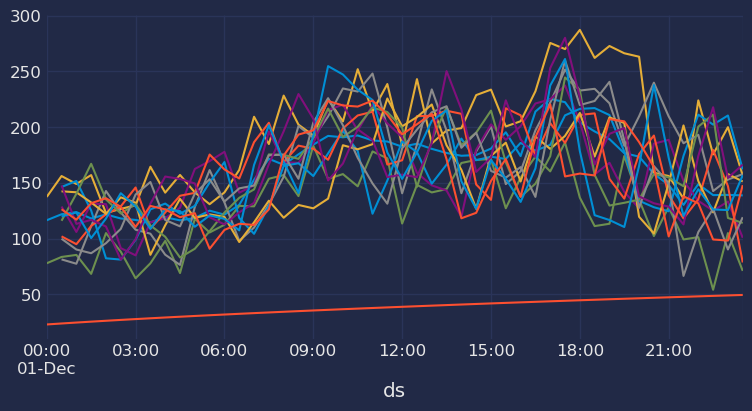

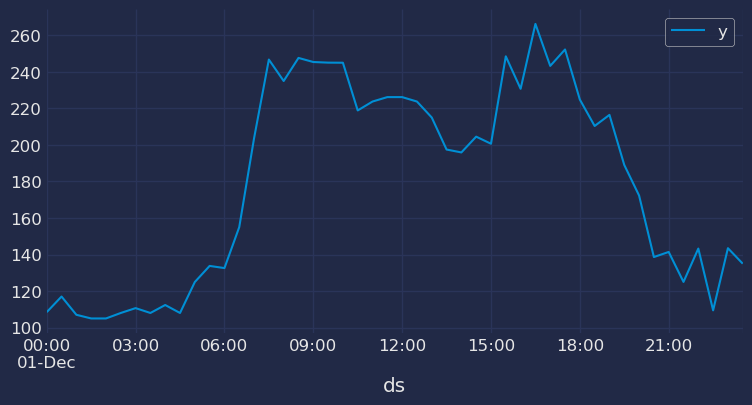

In [133]:
def monte_carlo(df, N=1):
    df = df.copy()
    '''Generates three scenarios-high, middle and low- based on the CI'''
    scenario_high = np.random.uniform(df['MSTL'], df['CI-hi'], len(df))
    scenario_low = np.random.uniform(df['CI-lo'], df['MSTL'], len(df))
    # scenario_high = pd.Series(scenario_high).rolling(window=2).mean().values
    # scenario_low = pd.Series(scenario_low).rolling(window=2).mean().values
    df['S_high'] = scenario_high
    df['S_low'] = scenario_low

    for n in range(N):
        scenario_middle = np.random.uniform(df['CI-lo'], df['CI-hi'], len(df))
        scenario_middle = pd.Series(
            scenario_middle).rolling(window=2).mean().values
        df[f'S_middle_{n}'] = scenario_middle
    return df


cv_scenarios = monte_carlo(prediction_with_ci, 10)
cv_scenarios.plot('ds', [*cv_scenarios.filter(like='S').columns], legend=False)
cv_scenarios.plot('ds', 'y', legend=True)
plt.legend()
plt.show()

In [134]:
# UIT DE DATA SCENARIOS SAMPLEN - ZONDER CI
grouped_train_ida1 = train_ida1.groupby(
    [train_ida1['ds'].dt.hour, train_ida1['ds'].dt.minute])['y'].describe()
grouped_train_ida1.head(4)

count        mean        std    min      25%      50%       75%     max
ds ds                                                                         
0  0   334.0  107.222904  35.283037 -38.62  92.1350  105.465  123.6425  215.00
   30  334.0  105.642635  37.285950 -23.97  88.2800  102.645  125.0825  212.40
1  0   334.0  103.219551  35.849367 -20.00  88.0275  101.150  120.5725  205.00
   30  334.0   98.404341  36.427131 -38.84  85.1800   98.400  118.2225  190.35

#### Test on predicted day


Coverage: 1.0


<Axes: xlabel='ds'>

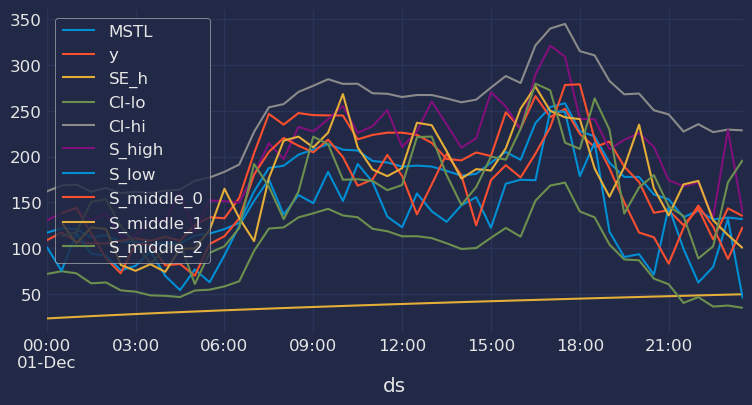

In [135]:
prediction_exo_ci = create_ci_95(prediction_exo, train_exo)
prediction_exo_scenarios = monte_carlo(prediction_exo_ci, 3)
prediction_exo_scenarios.drop(
    columns=['unique_id']).plot('ds')

In [136]:
prediction_exo_scenarios.columns

Index(['ds', 'MSTL', 'unique_id', 'y', 'SE_h', 'CI-lo', 'CI-hi', 'S_high',
       'S_low', 'S_middle_0', 'S_middle_1', 'S_middle_2'],
      dtype='object')

In [137]:
prediction_exo_scenarios['SE_h'].values

array([23.03825992, 23.90793219, 24.7470609 , 25.5586546 , 26.34525814,
       27.10904698, 27.85189813, 28.57544455, 29.28111734, 29.97017908,
       30.64375036, 31.30283114, 31.94831825, 32.58101964, 33.20166625,
       33.81092196, 34.40939182, 34.99762916, 35.57614156, 36.14539597,
       36.70582313, 37.25782137, 37.80175994, 38.3379819 , 38.86680663,
       39.38853208, 39.9034367 , 40.41178123, 40.91381019, 41.40975327,
       41.89982658, 42.38423373, 42.86316682, 43.33680735, 43.805327  ,
       44.26888834, 44.72764555, 45.18174496, 45.63132564, 46.07651985,
       46.51745353, 46.95424671, 47.38701389, 47.81586439, 48.24090265,
       48.66222858, 49.07993777, 49.49412181])

In [138]:
# prediction_exo_scenarios.fillna(method='bfill', inplace=True)
# prediction_exo_scenarios.drop(columns=['unique_id']).to_excel(
#     'ida_predictions.xlsx', index=False)

### DA


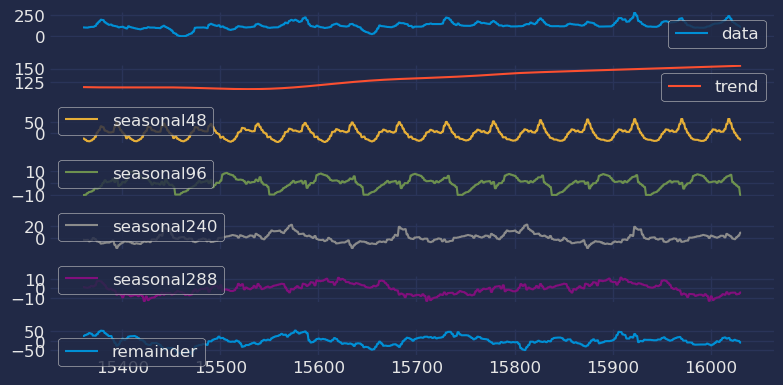

In [139]:
day = 48
da_mstl = create_MSTL(seasons=[day, day*2, day*5, day*6])
da_mstl.fit(train_da)
da_mstl.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

MAE: 29.42776929855347


/Users/tijnschutte/opt/anaconda3/envs/scriptie/lib/python3.11/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


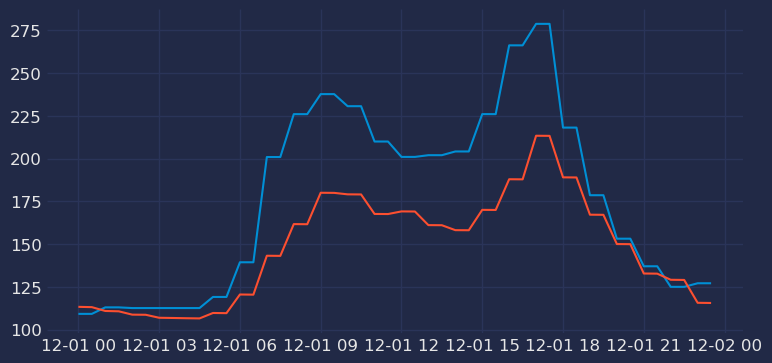

In [140]:
predictions_da = da_mstl.predict(h=day)
plt.plot(test_da['ds'].head(day), test_da['y'].head(day))
plt.plot(predictions_da['ds'], predictions_da['MSTL'])
mae = np.mean(
    np.abs(predictions_da['MSTL'].values - test_da['y'].head(day).values))
print("MAE:", mae)
plt.show()

In [141]:
predictions_da = predictions_da.merge(test_da[['ds', 'y']].head(day), on='ds')
da_std_erros = train_da['y'].std() / np.sqrt(len(predictions_da))
predictions_da['h'] = predictions_da.groupby(
    predictions_da['ds'].dt.date).cumcount() + 1
predictions_da['SE_h'] = da_std_erros * np.sqrt(predictions_da['h'])
print(predictions_da.columns)
# predictions_da.to_excel('../Data/da_prediction.xlsx', index=False)

Index(['ds', 'MSTL', 'y', 'h', 'SE_h'], dtype='object')


In [142]:
train_ida2_filtered = train_ida2.copy()
train_ida2_filtered.dropna(inplace=True)
train_ida2_filtered.reset_index(drop=True, inplace=True)
train_ida2_filtered

,ds,unique_id,y
0,2023-01-01 11:00:00,1,168.40
1,2023-01-01 11:30:00,1,193.72
2,2023-01-01 12:00:00,1,172.72
3,2023-01-01 12:30:00,1,197.18
4,2023-01-01 13:00:00,1,204.73
...,...,...,...
8011,2023-11-30 20:30:00,1,124.09
8012,2023-11-30 21:00:00,1,132.74
8013,2023-11-30 21:30:00,1,118.34
8014,2023-11-30 22:00:00,1,109.06


In [143]:
trading_length = len(train_ida2_filtered.groupby(
    train_ida2_filtered.ds.dt.hour)) * 2

In [144]:
model_ida2 = create_MSTL(
    seasons=[trading_length, 2*trading_length, 5*trading_length, 6*trading_length])
forecast_ida2 = model_ida2.forecast(df=train_ida2_filtered, h=trading_length)
forecast_ida2.reset_index(drop=True, inplace=True)
forecast_ida2['ds'] = test_ida2.dropna().head(
    trading_length)['ds'].reset_index(drop=True)

/Users/tijnschutte/opt/anaconda3/envs/scriptie/lib/python3.11/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [145]:
# crossvalidation_df = model_ida2.cross_validation(
#     df=train_ida2_filtered, h=48, step_size=48, n_windows=30)

In [146]:
# nan_mask = train_ida2.groupby('ds')['y'].apply(lambda x: x.isna().all())
# valid_times = nan_mask[nan_mask == False].index
# crossvalidation_df = crossvalidation_df[crossvalidation_df['ds'].isin(
#     valid_times)]
# crossvalidation_df['error'] = crossvalidation_df['y'] - \
#     crossvalidation_df['MSTL']
# crossvalidation_df.to_excel('../Data/cross_val_30_days_ida2.xlsx', index=False)

In [147]:
res = {
    "2023-12-01": {
        "overall_profit": 5855.5999999999985,
        "stages": {
            "DA": {
                "profit": 5855.5999999999985,
                "forecasted_profit": 3699.119949340819
            }
        }
    },
    "2023-12-02": {
        "overall_profit": 3055.5,
        "stages": {
            "DA": {
                "profit": 3055.5,
                "forecasted_profit": 3401.046943664551
            }
        }
    },
    "2023-12-03": {
        "overall_profit": 1574.2,
        "stages": {
            "DA": {
                "profit": 1574.2,
                "forecasted_profit": 4873.186378479003
            }
        }
    },
    "2023-12-04": {
        "overall_profit": 2175.2000000000003,
        "stages": {
            "DA": {
                "profit": 2175.2000000000003,
                "forecasted_profit": 3222.878112792969
            }
        }
    },
    "2023-12-05": {
        "overall_profit": 3623.4,
        "stages": {
            "DA": {
                "profit": 3623.4,
                "forecasted_profit": 3739.3245697021484
            }
        }
    },
    "2023-12-06": {
        "overall_profit": 2280.7,
        "stages": {
            "DA": {
                "profit": 2280.7,
                "forecasted_profit": 3543.1517791748056
            }
        }
    },
    "2023-12-07": {
        "overall_profit": 1456.6999999999998,
        "stages": {
            "DA": {
                "profit": 1456.6999999999998,
                "forecasted_profit": 3527.13996887207
            }
        }
    },
    "2023-12-08": {
        "overall_profit": 1570.1500000000005,
        "stages": {
            "DA": {
                "profit": 1570.1500000000005,
                "forecasted_profit": 3737.9923629760747
            }
        }
    },
    "2023-12-09": {
        "overall_profit": 506.3999999999994,
        "stages": {
            "DA": {
                "profit": 506.3999999999994,
                "forecasted_profit": 2563.702964782714
            }
        }
    },
    "2023-12-10": {
        "overall_profit": 2587.5,
        "stages": {
            "DA": {
                "profit": 2587.5,
                "forecasted_profit": 2236.958808898926
            }
        }
    }
}

In [148]:
profits = []
for date, data in res.items():
    profits.append(data['overall_profit'])
print(sum(profits))
print(np.std(profits))


24685.35
1405.9390100658702
